In [36]:
import pandas as pd
import matplotlib.pyplot as plt

## Preview of the Data

In [37]:
df = pd.read_csv("../data/final/1919.csv")
df = df[df['state'] == 'illinois']
df.head()

,year,state,april-avg-temp,may-avg-temp,june-avg-temp,july-avg-temp,august-avg-temp,september-avg-temp,october-avg-temp,november-avg-temp,...,november-pdsi-lagged,price-received-lagged,silage-yield-lagged,grain-yield-lagged,april-nov-avg-temp,april-nov-precipitation,april-nov-pdsi,april-nov-avg-temp-lagged,april-nov-precipitation-lagged,april-nov-pdsi-lagged
0,1919,illinois,52.1,58.9,74.2,78.0,72.6,68.8,56.8,38.4,...,-2.88,0.58,6.8,35.0,62.5,30.83,0.225714,61.1,22.70,-1.155714
6,1920,illinois,45.9,60.3,71.3,73.8,71.4,68.5,59.2,38.5,...,1.41,0.47,7.3,35.0,61.1,22.70,-1.155714,64.0,30.33,-0.670000
12,1921,illinois,54.2,64.2,75.6,79.6,73.0,70.3,54.3,40.6,...,-3.39,0.69,7.2,35.5,64.0,30.33,-0.670000,63.6,22.54,-2.077143
18,1922,illinois,52.6,65.5,73.2,74.2,74.0,69.1,57.1,43.1,...,0.83,0.78,7.0,37.5,63.6,22.54,-2.077143,61.2,26.67,-0.520000
24,1923,illinois,50.0,60.2,72.4,76.3,73.0,65.4,50.4,41.8,...,-1.03,1.02,6.5,33.0,61.2,26.67,-0.520000,60.4,26.24,0.765714


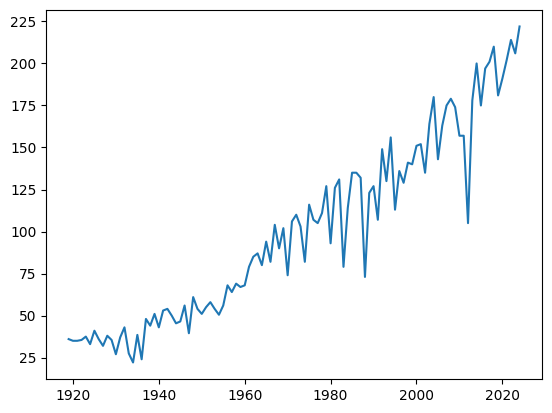

In [38]:
plt.plot(df['year'], df['grain-yield'])

## Time Series Analysis

### Stationarity Test

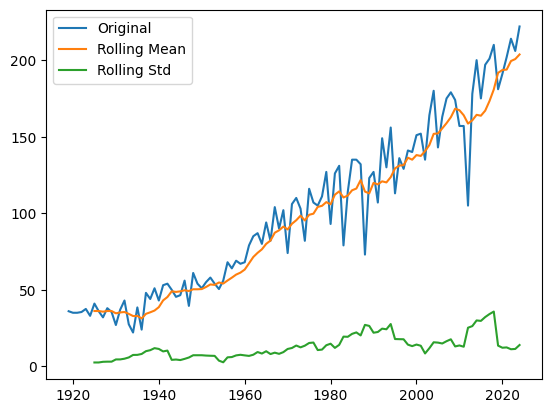

In [39]:
df2 = df[["year", 'grain-yield']].set_index("year")
rolling_mean = df2.rolling(7).mean()
rolling_std = df2.rolling(7).std()
plt.plot(df2, label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()

In [40]:
from statsmodels.tsa.stattools import adfuller

adft = adfuller(df2,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
output_df

,Values,Metric
0,1.591182,Test Statistics
1,0.997831,p-value
2,6.000000,No. of lags used
3,99.000000,Number of observations used
4,-3.498198,critical value (1%)
5,-2.891208,critical value (5%)
6,-2.582596,critical value (10%)


p-value is greater than 0.05, so data is assumed to be not stationary.

### Autocorrelation

In [41]:
autocorrelation_lag1 = df2['grain-yield'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = df2['grain-yield'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df2['grain-yield'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df2['grain-yield'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

One Month Lag:  0.9330903120138702
Three Month Lag:  0.9311560523378669
Six Month Lag:  0.9187547314737365
Nine Month Lag:  0.9097886587464493


### Decomposition

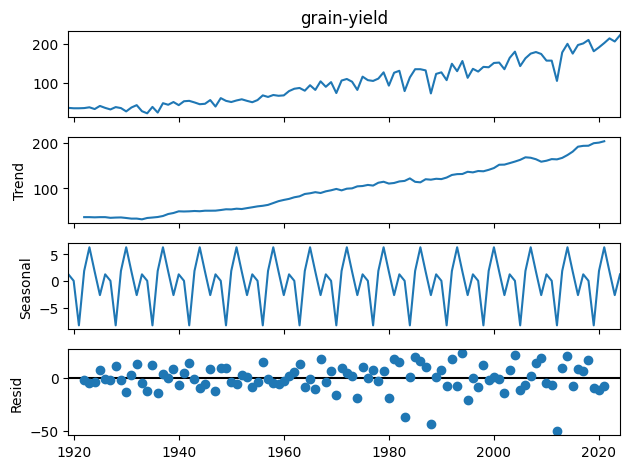

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df2['grain-yield'],model='additive', period=7)
decompose.plot()
plt.show()

In [43]:
df2['yield-diff'] = df2['grain-yield'].diff().dropna()
df2 = df2.drop(1919, axis=0)

In [44]:
from statsmodels.tsa.stattools import adfuller

adft = adfuller(df2["yield-diff"],autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
output_df

,Values,Metric
0,-7.100151e+00,Test Statistics
1,4.188480e-10,p-value
2,5.000000e+00,No. of lags used
3,9.900000e+01,Number of observations used
4,-3.498198e+00,critical value (1%)
5,-2.891208e+00,critical value (5%)
6,-2.582596e+00,critical value (10%)


### Random Forest Regressor

In [45]:
df = pd.read_csv("../data/final/1919.csv")
df = df[df['state'] == 'illinois']
df = df.set_index('year')

### Initial Model

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

target = df['grain-yield']
features = df.drop(['grain-yield', 'state'], axis=1)


scores = []
for i in range(len(features.columns)):
    if i == 0:
        continue
    model = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_features=i)
    cross_val = KFold(n_splits=5, shuffle=True, random_state=207)
    test_fold_r2 = cross_val_score(model, features, target, cv=cross_val, scoring="r2")
    scores.append(test_fold_r2.mean())

scores = np.array(scores)

Text(0.5, 1.0, 'Random Forest Feature Selection')

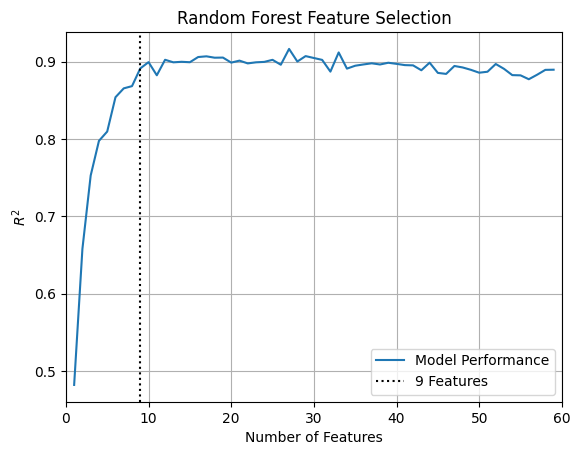

In [47]:
plt.plot(np.arange(1, len(features.columns), 1), scores, label='Model Performance')
plt.xlabel("Number of Features")
plt.ylabel("$R^2$")
plt.grid()
plt.xlim(0,60)
plt.axvline(9, color='k', ls='dotted', label='9 Features')
plt.legend()
plt.title("Random Forest Feature Selection")

In [ ]:
model = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_features=10, random_state=207)
cross_val = KFold(n_splits=5, shuffle=True, random_state=207)
test_fold_r2 = cross_val_score(model, features, target, cv=cross_val, scoring="r2")
print(f"Test fold R^2 Values: {test_fold_r2}")
print(f"Test fold R^2 Mean: {test_fold_r2.mean()}")
print(f"Test fold R^2 STD: {test_fold_r2.std()}")

Test fold R^2 Values: [0.93430492 0.88368054 0.77280589 0.92416722 0.93770118 0.81501131]
Test fold R^2 Mean: 0.8779451762300994
Test fold R^2 STD: 0.06315525071420897


In [49]:
model.fit(features, target)
pd.DataFrame({'Feature Importance': model.feature_importances_}, index=features.columns).sort_values(by='Feature Importance', ascending=False).iloc[0:9]

,Feature Importance
grain-yield-lagged,0.183910
population-density,0.163583
silage-yield,0.157447
price-received,0.105456
silage-yield-lagged,0.095605
price-received-lagged,0.071159
july-precipitation,0.025837
november-avg-temp,0.011652
april-nov-precipitation,0.011117


Text(0.5, 1.0, '$R^2$: 0.9849498895589246')

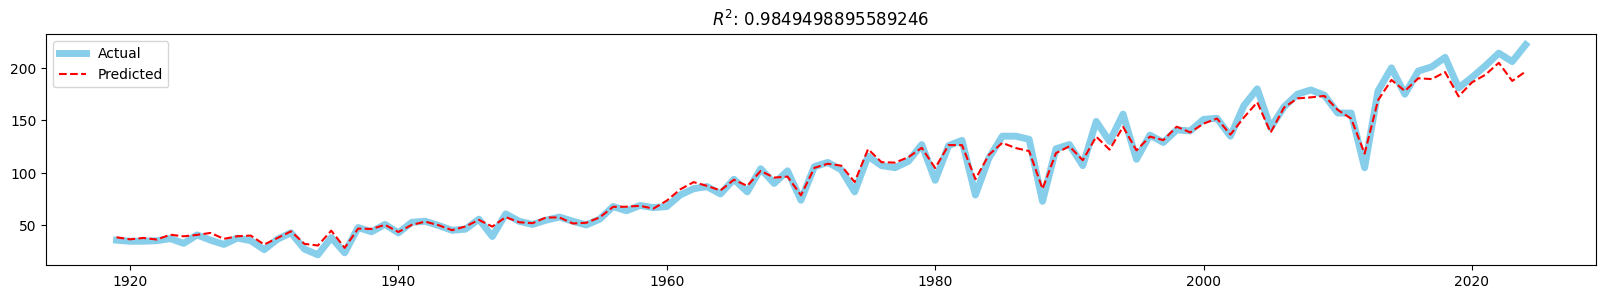

In [71]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(np.arange(1919, 2025, 1), df['grain-yield'], label="Actual", color='skyblue', linewidth=5)
ax.plot(np.arange(1919, 2025, 1), model.predict(features), label="Predicted", color='red', linestyle='--')
plt.legend()
plt.title(f"$R^2$: {model.score(features, target)}")